In [10]:
# Importing packages needed
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from astroquery.utils.tap.core import Tap
import astropy.coordinates as coord
import astropy.units as u
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import join
import time

In [12]:
def cross_reference_gaia_starhorse(object_name, radius_deg):
    simbad_result_table = Simbad.query_object(object_name)

    if simbad_result_table is not None and 'RA' in simbad_result_table.colnames and 'DEC' in simbad_result_table.colnames:
        simbad_ra = simbad_result_table['RA'][0]
        simbad_dec = simbad_result_table['DEC'][0]

        simbad_coord = coord.SkyCoord(simbad_ra, simbad_dec, unit=(u.deg, u.deg), frame="icrs")

        gaia_query = f"SELECT * FROM gaiadr3.gaia_source WHERE CONTAINS(POINT('ICRS', gaiadr3.gaia_source.ra, gaiadr3.gaia_source.dec), CIRCLE('ICRS', {simbad_coord.ra.deg}, {simbad_coord.dec.deg}, {radius_deg})) = 1"
        gaia_job = Gaia.launch_job_async(gaia_query)
        gaia_result = gaia_job.get_results()
        if len(gaia_result) > 0:
            # Perform the crossmatch using TAP (Table Access Protocol)
            tap_service_url = "http://tapvizier.u-strasbg.fr/TAPVizieR/tap/"
            tap_service = Tap(url=tap_service_url)
            # Selecting Starhorse catalog
            query = f"SELECT * FROM \"I/354/starhorse2021\" WHERE CONTAINS(POINT('ICRS', \"RA_ICRS\", \"DE_ICRS\"), CIRCLE('ICRS', {simbad_coord.ra.deg}, {simbad_coord.dec.deg}, {radius_deg})) = 1"
            max_retries = 3
            retry_delay = 10  # seconds
            for attempt in range(1, max_retries + 1):
                try:
                    starhorse_job = tap_service.launch_job_async(query)
                    starhorse_result = starhorse_job.get_results()
                    break  # Break out of the loop if successful
                except TimeoutError as e:
                    print(f"TimeoutError: {e}. Retrying after {retry_delay} seconds...")
                    time.sleep(retry_delay)
            else:
                raise RuntimeError(f"Failed after {max_retries} attempts. Aborting.")
        
            return gaia_result, starhorse_result
        else:
            print("No Gaia sources found in the specified radius.")
            return None, None
    else:
        print(f"Simbad query for object {object_name} returned no results. Returning None.")
        return None, None

def save_to_csv(results, filename):
    if results is not None:
        #df = results.to_pandas()
        results.to_csv(filename, index=False)
    else:
        print("Results are empty. Not saving to CSV.")

def main():
    # Change this to your object name for the Simbad query
    object_name = "NGC 2264"

    # Change this to your radius for the cone search (in degrees)
    radius_deg = 1

    # Perform cross-referencing with cone search
    gaia_result, starhorse_result = cross_reference_gaia_starhorse(object_name, radius_deg)

    # Check if results are not empty
    if gaia_result is not None and starhorse_result is not None:

        # Print column names for debugging
        print("Gaia Columns:", gaia_result.colnames)
        print("StarHorse Columns:", starhorse_result.colnames)

        # Merge based on column names
        starhorse_result.rename_column('Source', 'SOURCE_ID')
        merged_results = join(gaia_result, starhorse_result, keys='SOURCE_ID', join_type='inner')
        
        # Add magnitude errors to Gaia data
        merged_results['phot_g_mean_mag_error']  = (2.5 / np.log(10)) * (merged_results['phot_g_mean_flux_error'] / merged_results['phot_g_mean_flux'])
        merged_results['phot_bp_mean_mag_error'] = (2.5 / np.log(10)) * (merged_results['phot_bp_mean_flux_error'] / merged_results['phot_bp_mean_flux'])
        merged_results['phot_rp_mean_mag_error'] = (2.5 / np.log(10)) * (merged_results['phot_rp_mean_flux_error'] / merged_results['phot_rp_mean_flux'])

        # Save the merged results to a single CSV file
        merged_results = merged_results.to_pandas()
        n_merged_results = merged_results.drop(['solution_id'], axis=1)
        save_to_csv(n_merged_results, 'Data/merged.csv')

        # Display the merged results
        print("Merged Results:")
        print(n_merged_results)

    else:
        print("No results to merge.")

if __name__ == "__main__":
    main()

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
Gaia Columns: ['solution_id', 'DESIGNATION', 'SOURCE_ID', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrometric_mat

Merged Results:
                       DESIGNATION            SOURCE_ID  random_index  \
0     Gaia DR3 2749164894942350976  2749164894942350976    1343843860   
1     Gaia DR3 2749164899237967872  2749164899237967872     518075566   
2     Gaia DR3 2749165792591164416  2749165792591164416      80114223   
3     Gaia DR3 2749353809079475840  2749353809079475840    1449211014   
4     Gaia DR3 2749353809079696640  2749353809079696640    1677133169   
...                            ...                  ...           ...   
3020  Gaia DR3 2754172143910256256  2754172143910256256    1270728782   
3021  Gaia DR3 2754172178269968384  2754172178269968384    1052769562   
3022  Gaia DR3 2754173342205693056  2754173342205693056     457596474   
3023  Gaia DR3 2754173415220577152  2754173415220577152     833514284   
3024  Gaia DR3 2754173999336128256  2754173999336128256     553155739   

      ref_epoch        ra  ra_error        dec  dec_error  parallax  \
0        2016.0  6.379102  0.135438 

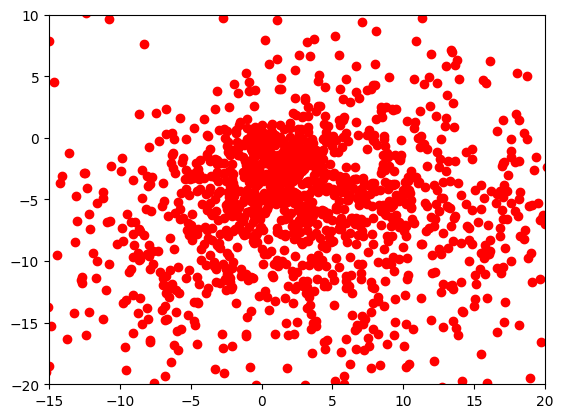

In [9]:
g = pd.read_csv('Data/merged_results.csv', index_col=False)

pmra = g['pmra']
pmdec = g['pmdec']

plt.scatter(pmra,pmdec, color='r')
plt.xlim(-15,20)
plt.ylim(-20,10)
plt.show()

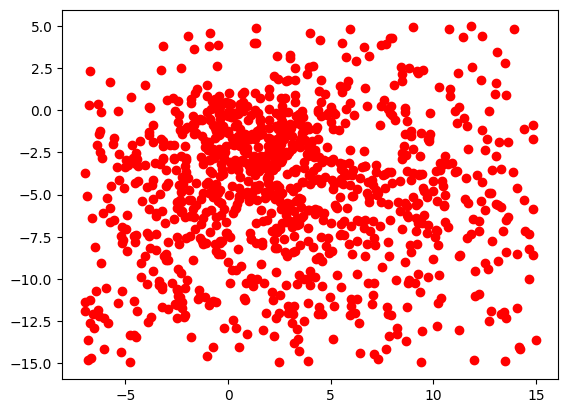

In [10]:
# Specify the condition to remove rows
condition = ((pmdec > -15) & (pmdec < 5)) & ((pmra > -7) & (pmra < 15))

# Apply the condition to filter rows
df = g.loc[condition]

# Save the DataFrame back to the CSV file
df.to_csv('Data/selected_NGC2264.csv', index=False)

r = pd.read_csv('Data/selected_NGC2264.csv', index_col=False)

pmra = r['pmra']
pmdec = r['pmdec']

plt.scatter(pmra, pmdec, color='r')
plt.show()

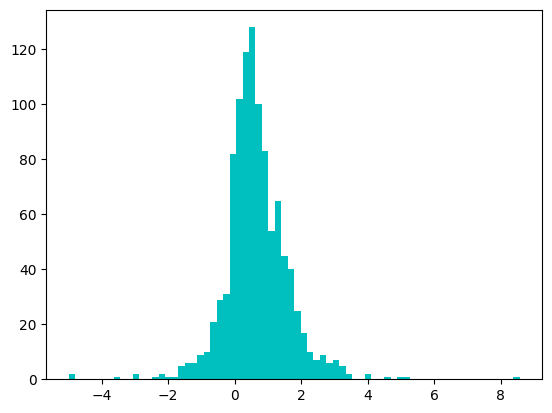

In [11]:
p = r['parallax']
plt.hist(p, color='c',bins='auto')
plt.show()

In [12]:
print(np.mean(p))

0.6500676113364516


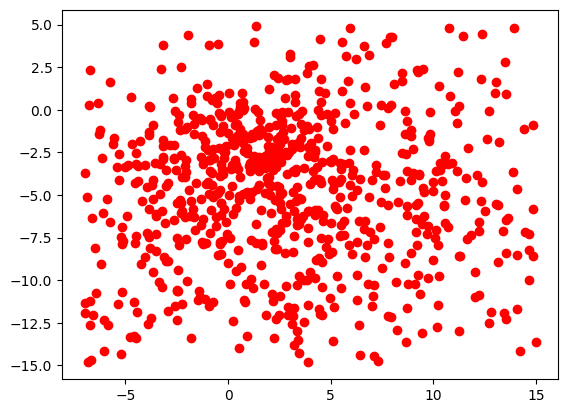

In [13]:
condition = ((p > 0) & (p < 1.7))
# Apply the condition to filter rows
df = r.loc[condition]

# Save the DataFrame back to the CSV file
df.to_csv('Data/parallax_selected_NGC2264.csv', index=False)
rp = pd.read_csv('Data/parallax_selected_NGC2264.csv', index_col=False)

pmra = rp['pmra']
pmdec = rp['pmdec']

plt.scatter(pmra, pmdec, color='r')
plt.show()

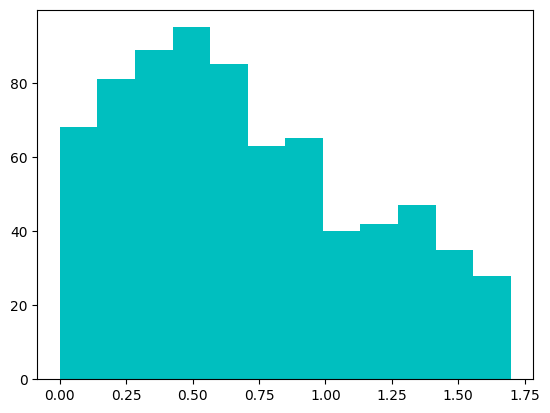

In [14]:
p = rp['parallax']
plt.hist(p, color='c',bins='auto')
plt.show()

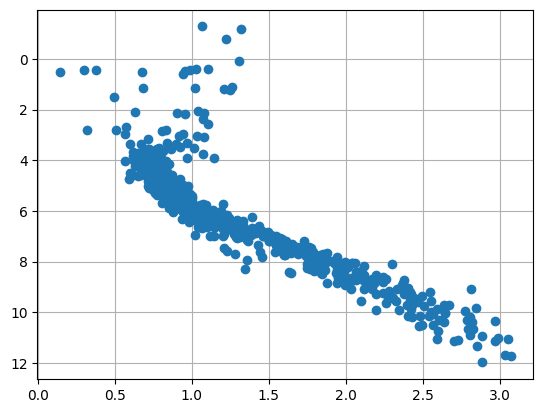

In [15]:
plt.scatter(rp['BP-RP0'],rp['GMAG0'],zorder=3)
plt.grid(zorder=0)
plt.gca().invert_yaxis()
plt.show()